In [1]:
%matplotlib inline

In [2]:
import os
import tempfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import dataframe_image as dfi
import cv2
from scripts.pdf_parser_class import PDFparser
import scripts.get_table_utils as tbu

In [3]:
def get_table_rows(file_path):
    parser = PDFparser(parse_method="camelot")
    df_marked = parser.get_rows_marked(file_path)
    
    tbl_rows = (df_marked
            .loc[df_marked["mark"] == "tbl_row", 0]
            .reset_index(drop=True))

    # hack to temporary remove hanging rows
    if tbl_rows.iloc[1].startswith("|"):
        tbl_rows = (tbl_rows
                    .loc[range(0, len(tbl_rows), 2)]
                    .reset_index(drop=True))
    return tbl_rows

In [4]:
mrgn = 10
font_scale = .35
thickness = 1
font = cv2.FONT_HERSHEY_SIMPLEX
line_type = cv2.LINE_AA

def make_pdf_image(file_path):
    tbl_rows = get_table_rows(file_path)

    longest_str = tbl_rows.iloc[tbl_rows.str.len().idxmax()]

    (w, h), baseline = cv2.getTextSize(longest_str,
                                       font,
                                       font_scale,
                                       thickness)

    line_height = h + baseline

    image = np.zeros((len(tbl_rows) * line_height + mrgn * 2,
                      w + mrgn * 2,
                      3), dtype="uint8")

    x, y0 = (mrgn, mrgn)
    for g, r in enumerate(tbl_rows):
        y = y0 + g * line_height        
        cv2.putText(image,
                    r,
                    (x, y),
                    font,
                    font_scale,
                    (255, 255, 255),
                    thickness,
                    line_type)
    return image

In [5]:
def make_df_image(file_path):
    tbl_rows = get_table_rows(file_path)
    df = tbu.get_table(tbl_rows)
    
    with tempfile.TemporaryDirectory() as tmpdirname:
        png_path = tmpdirname + "/temp_df.png"
        dfi.export(df, png_path)
        image = mpimg.imread(png_path)
        
    return image   

In [6]:
pdf_pths = [str(pth) for pth
            in Path("../../task_description/examples/").iterdir()
            if pth.suffix == ".pdf"]

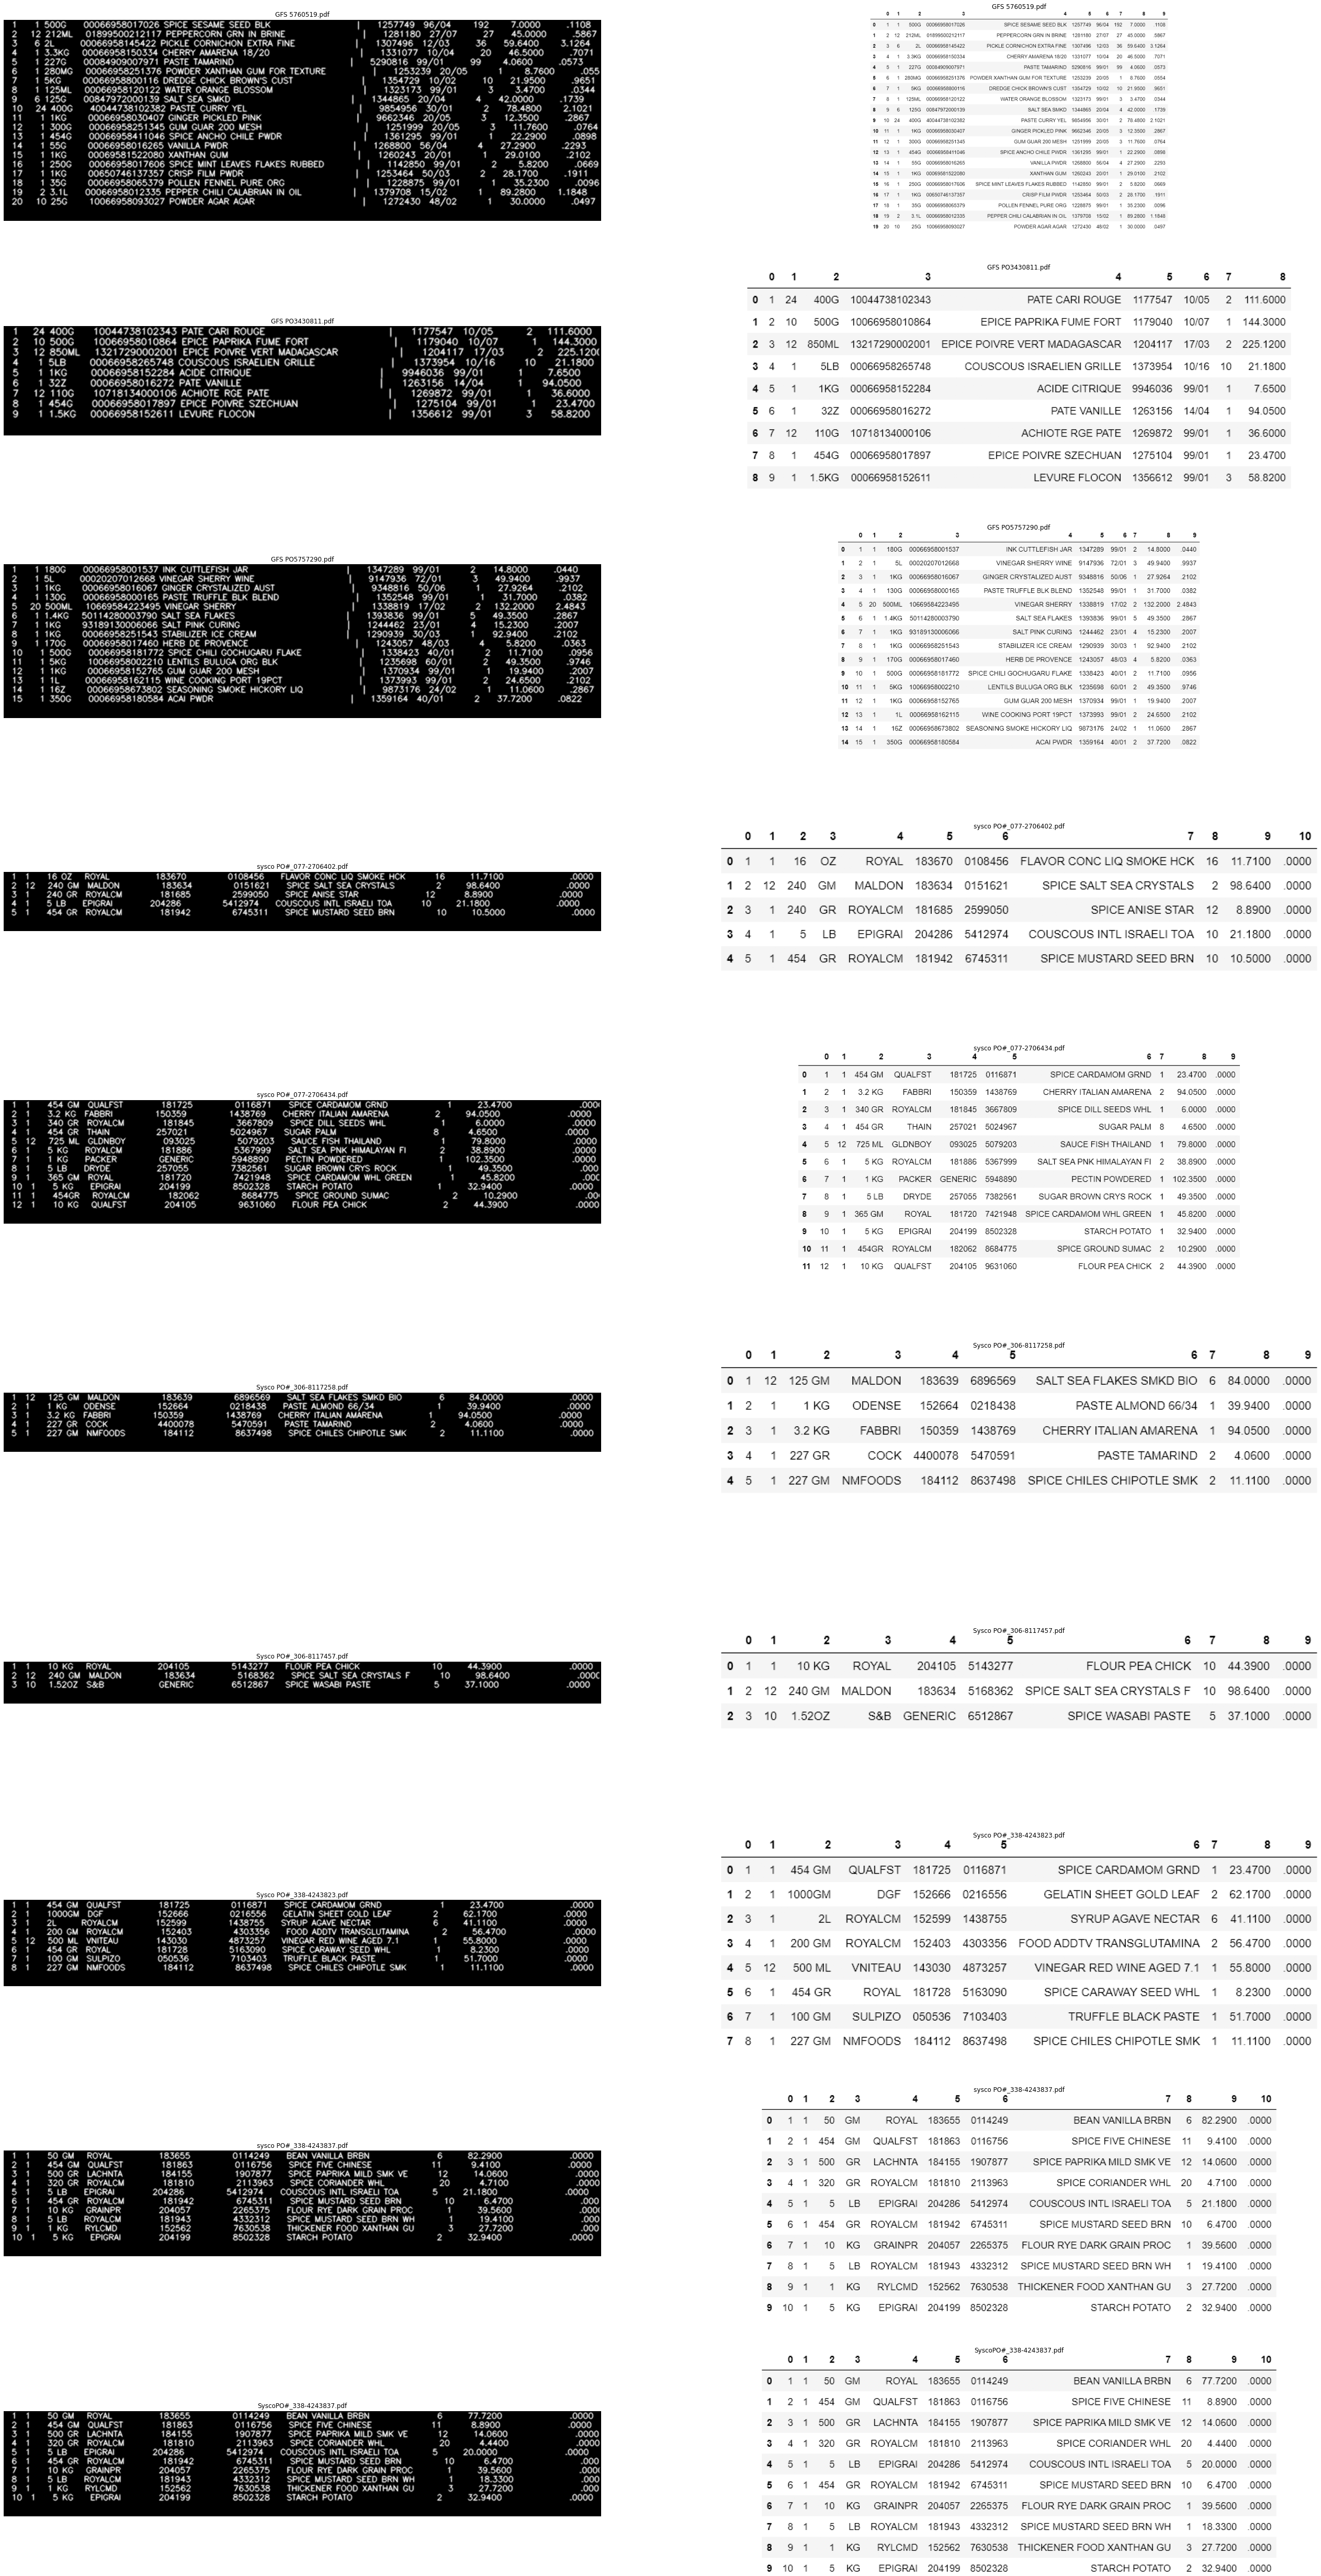

In [7]:
funcs = [make_pdf_image, make_df_image]
fig, ax = plt.subplots(len(pdf_pths), 2,                       
                       figsize=(45, 90))

for i, p in enumerate(pdf_pths):
    for j, fun in enumerate(funcs):
        ax[i, j].axis("off")
        ax[i, j].set_adjustable("box")
        ax[i, j].title.set_text(os.path.basename(pdf_pths[i]))  
        ax[i, j].imshow(fun(pdf_pths[i]))    